# Passo à Passo das Redes Neurais

A criação e treinamento de uma rede neural tem alguns passos que foram um *pipeline* completo.
Nesta aula, vamos ver cada passo para criar e treinar uma rede neural do zero usando PyTorch.

## Imports e configurações iniciais

Agora que a brincadeira está ficando séria, que tal uma sugestão de como organizar o seu código? Para facilitar o entendimento e manutenção do código, mantenha sempre no início os seguintes elementos:
* imports de pacotes
* configuração de **hiperparâmetros**
* definição do hardware padrão utilizado

Nessa aula vamos trabalhar com dados reais, então **vamos precisar de GPU!** Então não se esqueça de mudar as configurações desse ambiente do colab. <br>
Sugiro rodar esse mesmo código sem GPU em outro momento, só pra sentir o gostinho de como a GPU facilitou o uso de redes neurais.


In [0]:
# Basic imports.
import os, sys, time
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torch.backends import cudnn
cudnn.benchmark = True

from torch.utils.data import DataLoader
from torch.utils import data

from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

Nesta célula, além da definição do hardware padrão, estão também definidos os hiperparâmetros do nosso modelo. Mais à frente conversaremos um pouco melhor sobre eles.

In [2]:
# Setting predefined arguments.
args = {
    'num_epochs': 20,      # Number of epochs.
    'num_classes': 10,     # Number of classes.
    'lr': 1e-4,            # Learning rate.
    'weight_decay': 5e-5,  # L2 penalty.
    'num_workers': 3,      # Number of workers on data loader.
    'batch_size': 100,      # Mini-batch size.
}

# Setting device (CPU | CUDA)
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


## Carregamento de Dados

#### **Datasets**

O PyTorch possui dois pacotes que trazem datasets prontos para uso.

* Torchtext: https://torchtext.readthedocs.io/en/latest/datasets.html
* Torchvision: https://pytorch.org/docs/stable/torchvision/datasets.html

Como os nomes indicam, são datasets de textos (text) e imagens (vision), duas aplicações onde redes neurais são muito bem sucedidas.

Para aplicações com textos e outros tipos de séries temporais, o carregamento de dados possui nuances que dificultam o entendimento, portanto vamos concentrar no carregamento de imagens.

Para trabalhar com datasets do pacote torchvision, basta
* Importar o pacote
``` python 
from torchvision import datasets 
```
* Carregar o dataset do seu interesse (ex: FashionMNIST)
``` python 
data = datasets.FashionMNIST(root, train=True, transform=None, target_transform=None, download=False)
```

> Note que o torch faz o carregamento das imagens no formato [Pillow](https://pillow.readthedocs.io/en/stable/). Portanto é necessário convertê-las para um tensor usando um [**Transformer**](https://pytorch.org/docs/stable/torchvision/transforms.html).

* Importar o pacote transforms
``` python 
from torchvision import transforms 
```
* preencher o parâmetro ```transform``` do dataset com a função que converte para tensor.
``` python 
transforms.ToTensor() 
```

Pronto! Quando seu dado for carregado, ele passará pela transformação indicada no parâmetro ```transform```, que nesse caso converte o dado para um tensor.


In [3]:
train_set = datasets.FashionMNIST('./', 
                           train=True, 
                           transform=transforms.ToTensor(),
                           download=True)

test_set = datasets.FashionMNIST('./', 
                           train=False, 
                           transform=transforms.ToTensor(),
                           download=False)

print('Amostras de treino: ' + str(len(train_set)) + '\nAmostras de Teste:' + str(len(test_set)))

Amostras de treino: 60000
Amostras de Teste:10000


Cada dataset possui uma implementação específica internamente no pytorch. Verifique o ```type``` da variável que recebeu os dados e veja que se refere a uma classe específica do dataset.

In [4]:
print(type(train_set))

<class 'torchvision.datasets.mnist.FashionMNIST'>


Por se tratar de um conjunto de dados **supervisionado**, cada elemento do dataset é definido por uma tupla `(dado, rótulo)`. Para dados não supervisionados, cada elemento do dataset comporta apenas o dado.

In [5]:
print(type(train_set[0]))

<class 'tuple'>


Podemos então iterar no dataset para observar algumas amostras e seus rótulos.

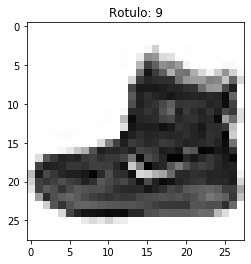

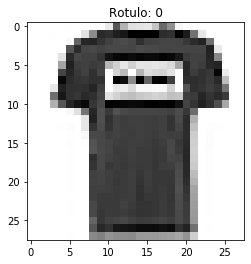

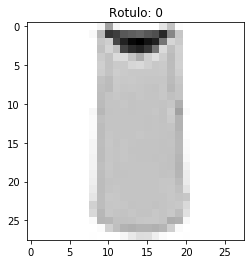

In [6]:
for i in range(3):
  dado, rotulo = train_set[i]
  
  plt.figure()
  plt.imshow(dado[0], cmap='Greys')
  plt.title('Rotulo: '+ str(rotulo))

Temos um total de 70 mil amostras, mas elas **ainda não estão carregadas na memória** (isso seria bastante custoso). A vantagem da classe ```Dataset``` do Pytorch é que as amostras só são carregadas quando necessário.

Para entender melhor, vamos experimentar a transformação a seguir
```python
transforms.RandomCrop(12)
```
Essa função realiza um recorte aleatório de ```12 x 12``` (pixels) na imagem. Ao carregar a mesma amostra múltiplas vezes, um novo recorte será feito. 

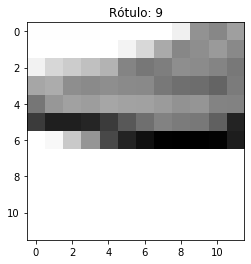

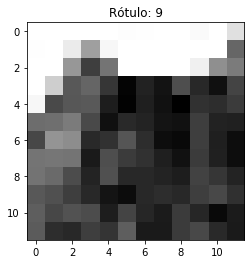

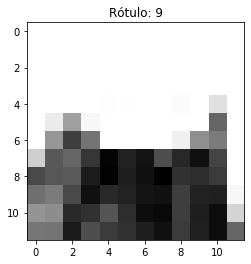

In [7]:
crop_set = datasets.FashionMNIST('./', 
                           train=False, 
                           transform=transforms.RandomCrop(12),
                           download=False)

# Tuple (dado, rótulo)
for i in range(3):
  dado, rotulo = crop_set[0]
  
  plt.figure()
  plt.imshow(dado, cmap='Greys')
  plt.title('Rótulo: '+ str(rotulo))

Em resumo, cada vez que indexamos um item do dataset, as seguintes operações são realizadas:
* Amostra lida do arquivo e carregada como uma tupla ```(dado, rótulo)```
* As transformações são aplicadas 


#### **Dataloader**



O [Dataloader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) gerencia muito bem o carregamento de dados para o treinamento de redes neurais, trazendo as funções: 

* Separação dos dados em batches
* Embaralhando os dados
* Carregando batches em paralelo utilizando threads

O uso de threads no carregamento minimiza períodos ociosos de processamento, visto que a leitura de dados em arquivo é um grande gargalo de tempo.

As três funcionalidades que acabamos de conhecer são controladas pelos parâmetros da chamada do DataLoader.
```python
loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
```


In [0]:
train_loader = DataLoader(train_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True, 
                          num_workers=args['num_workers'])

test_loader = DataLoader(test_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True, 
                          num_workers=args['num_workers'])

O objeto retornado é um **iterador**, podendo ser utilizado para iterar em loops mas não suportando indexação.

torch.Size([100, 1, 28, 28]) torch.Size([100])


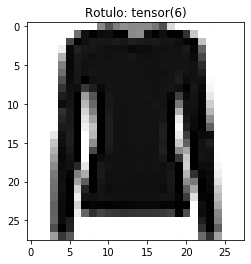

In [9]:
for batch in train_loader:
  
  dado, rotulo = batch
  print(dado.size(), rotulo.size())

  plt.imshow(dado[0][0], cmap='Greys')
  plt.title('Rotulo: '+ str(rotulo[0]) )
  break

Vale a pena visitar o [tutorial de carregamento de dados do PyTorch](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) que introduz o uso das classes Dataset e Dataloader.

## Definindo a Arquitetura

#### **Classe nn.Module**

O [nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) é a classe base para todos os módulos de redes neurais. 

A forma mais organizada de definir modelos em PyTorch é implementando uma classe. Para redes tradicionais, como as que estamos aprendendo até o momento, sua importância pode não se destacar, mas modelos maiores e com funcionalidades mais complexas, são mais fáceis de implementar e realizar manutenções dessa forma.

Para implementar uma subclasse da ```nn.Module``` basta definir a subclasse da seguinte forma:
```python
class MinhaRede(nn.Module):
  # resto do código
```

Funções obrigatórias de subclasses da ```nn.Module```.
* ```__init()__```: definição da arquitetura da rede no estado interno da classe.
* ```forward()```: Fluxo da entrada ao longo da rede e retorno da saída.

**Implemente a seguir** a CNN descrita nos slides da aula.


In [0]:
## TODO: Definir a classe que implementa o MLP ##

class MinhaRede(nn.Module):
  
  def __init__(self,):
    super(MinhaRede, self).__init__()
    
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    
    self.classifier = nn.Sequential(
        nn.Linear(64*7*7, 200),
        nn.Dropout(),
        nn.ReLU(),
        nn.Linear(200, 50),
        nn.Dropout(),
        nn.ReLU(),
        nn.Linear(50, 10),
    )
    
  def forward(self, x):
    
    ## Implementar o forward
    feat1 = self.conv1(x)
    feat2 = self.conv2(feat1)

    feat2 = feat2.view(feat2.size(0), -1)
    out   = F.log_softmax(self.classifier(feat2))

    return out


#################################################

Instanciando a rede

In [11]:
## TODO: Instanciar o objeto que conterá a rede ##
net = MinhaRede().to(args['device'])
print(net)
##################################################

MinhaRede(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=200, 

## Função de Perda e Otimizador

Por se tratar de um problema de classificação usaremos a função de custo [`CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss).

Como o [`Adam`](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) é considerado um dos melhores otimizadores atualmente, usaremos ele na nossa abordagem. Lembre-se que os otimizadores fazem parte do pacote `torch.optim`.


In [0]:
# Define Loss
 criterion = nn.NLLLoss().to(args['device'])
# Define Optimizer
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

## Fluxo de Treinamento

**Agora implemente a seguir** um fluxo completo de treinamento. Relembrando o passo a passo:

* Iterar nas épocas (Número de épocas definido em `args['num_epochs']`)
* Iterar nos batches (*loaders* pré definidos que retornam uma tupla `(dado, rótulo)`)
* Cast dos dados no dispositivo de hardware (Dispositivo definido em `args['device']`)
* Zere o gradiente dos parâmetros (`optimizer.zero_grad()`) 
* Forward do batch na rede 
* Cálculo da loss (`criterion` previamente definido)
* Cálculo do gradiente a partir da loss (`loss.backward()`)
* Atualização dos pesos (`optimizer.step()`)
* Cálculo das predições a partir da saída da rede
```python
pred = output.max(1, keepdim=True)[1]
```

> Armazene as predições e os rótulos de cada iteração em uma lista para permitir o cálculo da acurácia futuramente.
```python
preds_list.append(preds)
labels_list.append(rotulo.cpu().numpy())
```
**Ao final de cada época** use a função [accuracy do sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) para calcular a acurácia.
```python
acc = metrics.accuracy_score(np.asarray(labels_list).ravel(),
                                 np.asarray(preds_list).ravel())
```


Para acompanhar a convergência do seu modelo (e garantir que tudo foi feito certinho), ao final de cada época podemos imprimir também a **média e o desvio padrão das perdas de cada iteração**. Imprima também a acurácia do treinamento.

In [0]:
## TODO: Fluxo de Treinamento ##
def train(train_loader, net, criterion, optimizer, epoch):
  start = time.time()
  net.train()
  
  epoch_loss  = []
  preds_list  = []
  labels_list = []
  for batch in train_loader:
    
    dado, rotulo = batch
    
    # Cast do dado na GPU
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])
    
    # Forward
    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().data)
    
    # Predições
    preds = ypred.data.max(dim=1)[1].cpu().numpy()
    preds_list.append(preds)
    labels_list.append(rotulo.cpu().numpy())
    
    # Backpropagation
    loss.backward()
    optimizer.step()
   
  epoch_loss = np.asarray(epoch_loss)

  acc = metrics.accuracy_score(np.asarray(labels_list).ravel(),
                                 np.asarray(preds_list).ravel())
  end = time.time()

  print('------------ Train -----------')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.4f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc, end-start))
    

################################

## Fluxo de Validação

Se você já conseguiu realizar o treinamento correto da rede (sua rede convergiu bem?), agora é hora de testar o modelo!

Transforme o fluxo de treinamento em uma função
```python
def train(train_loader, net, criterion, optimizer)
```

Crie a função de validação
```python
def validate(test_loader, net, criterion, optimizer)
```

E crie um loop onde a cada época é chamada a função de treino e em seguida validação.

**O que vai mudar no fluxo de validação, em relação ao treino?**

Para essa etapa, o PyTorch oferece dois artifícios:
* ```model.eval()```: Impacta no *forward* da rede, informando as camadas caso seu comportamento mude entre fluxos (ex: dropout).
* ```with torch.no_grad()```: Gerenciador de contexto que desabilita o cálculo e armazenamento de gradientes (economia de tempo e memória). Todo o código de validação deve ser executado dentro desse contexto.

Exemplo de código para validação

```python
net.eval()
with torch.no_grad():
  for batch in test_loader:
      # Código de validação
```

Existe o equivalente ao ```model.eval()``` para explicitar que a sua rede deve estar em modo de treino, é o ```model.train()```. Apesar de ser o padrão dos modelos, **é boa prática definir também o modo de treinamento**.

> Atenção: Não é necessário realizar o backpropagation (cálculo do gradiente e atualização dos pesos). 


In [0]:
## TODO: Fluxo de Validação ##
def validate(test_loader, net, criterion, epoch):

  # Evaluation mode
  net.eval()
  
  start = time.time()
  
  epoch_loss  = []
  preds_list  = []
  labels_list = []
  with torch.no_grad(): 
    for batch in test_loader:

      dado, rotulo = batch

      # Cast do dado na GPU
      dado = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.cpu().data)

      # Predições
      preds = ypred.data.max(dim=1)[1].cpu().numpy()
      preds_list.append(preds)
      labels_list.append(rotulo.cpu().numpy())

  epoch_loss = np.asarray(epoch_loss)

  acc = metrics.accuracy_score(np.asarray(labels_list).ravel(),
                                 np.asarray(preds_list).ravel())
  
  end = time.time()
  print('********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.4f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc, end-start))
    

################################

In [15]:
## Loop nas épocas ##
for epoch in range(args['num_epochs']):
  # Train
  train(train_loader, net, criterion, optimizer, epoch)
  
  # Validate
  validate(test_loader, net, criterion, epoch)
################################

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


------------ Train -----------
Epoch 0, Loss: 1.0538 +/- 0.3500, Acc: 0.6177, Time: 9.29
********** Validate **********
Epoch 0, Loss: 0.6035 +/- 0.1225, Acc: 0.7787, Time: 1.18
------------ Train -----------
Epoch 1, Loss: 0.7682 +/- 0.1255, Acc: 0.7182, Time: 8.65
********** Validate **********
Epoch 1, Loss: 0.5572 +/- 0.0785, Acc: 0.7879, Time: 1.28
------------ Train -----------
Epoch 2, Loss: 0.7135 +/- 0.1330, Acc: 0.7403, Time: 9.17
********** Validate **********
Epoch 2, Loss: 0.5105 +/- 0.1121, Acc: 0.8067, Time: 1.13
------------ Train -----------
Epoch 3, Loss: 0.6621 +/- 0.1405, Acc: 0.7597, Time: 8.59
********** Validate **********
Epoch 3, Loss: 0.4971 +/- 0.1035, Acc: 0.8177, Time: 1.22
------------ Train -----------
Epoch 4, Loss: 0.6293 +/- 0.1290, Acc: 0.7680, Time: 8.88
********** Validate **********
Epoch 4, Loss: 0.4551 +/- 0.0796, Acc: 0.8239, Time: 1.18
------------ Train -----------
Epoch 5, Loss: 0.5809 +/- 0.1127, Acc: 0.7863, Time: 9.13
********** Validate *